<a href="https://colab.research.google.com/github/merveenoyan/siglip/blob/main/Text_Retrieval_FAISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Retrieval with FAISS support of datasets

This notebook walks you through how to use SigLIP model to get embeddings and index them using FAISS integration of datasets.
Let's install necessary libraries.

In [1]:
!pip install datasets faiss-gpu git+https://github.com/huggingface/transformers.git sentencepiece

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-pkubgr7f
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-pkubgr7f
  Resolved https://github.com/huggingface/transformers.git to commit fff8ca8e597532f141bc3f522f47573320a06730
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


We will use a small dataset where there's pokemons and their captions.



In [1]:
from datasets import load_dataset

dataset = load_dataset("lambdalabs/pokemon-blip-captions")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Let's load the model and the tokenizer.

In [2]:
#Import packages
import torch
from PIL import Image
from transformers import AutoProcessor, SiglipModel, AutoImageProcessor, AutoModel, AutoTokenizer
import faiss
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)
model = SiglipModel.from_pretrained("google/siglip-base-patch16-224").to(device)
tokenizer = AutoTokenizer.from_pretrained("google/siglip-base-patch16-224")
dataset = dataset["train"]

We can use `map` to get the embeddings and write them to an "embeddings" column.

In [3]:
ds_with_embeddings = dataset.map(lambda example: {'embeddings': model.get_text_features(**tokenizer([example["text"]], return_tensors="pt").to("cuda"))[0].detach().cpu().numpy()})

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

`add_faiss_index` method will create the index.

In [4]:
ds_with_embeddings.add_faiss_index(column='embeddings')

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'text', 'embeddings'],
    num_rows: 833
})

We can now query the index. First, we get the embeddings of the input, and then call `get_nearest_examples` on embeddings column with the embeddings of the query.

In [5]:
prmt = "a green pokemon"
prmt_embedding = model.get_text_features(**tokenizer([prmt], return_tensors="pt", truncation=True).to("cuda"))[0].detach().cpu().numpy()
scores, retrieved_examples = ds_with_embeddings.get_nearest_examples('embeddings', prmt_embedding, k=3)

Let's see the closest text.

In [7]:
retrieved_examples["text"][0]

'a green pokemon sitting on top of a leaf'

We can also get the image of the closest text from the dataset.



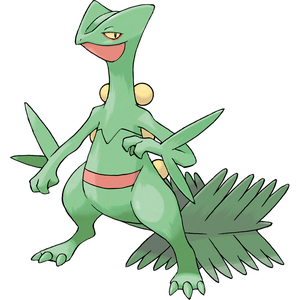

In [10]:
img = retrieved_examples["image"][0]

# downscale to display
width = 300
ratio = (width / float(img.size[0]))
height = int((float(img.size[1]) * float(ratio)))
img = img.resize((width, height), Image.Resampling.LANCZOS)
display(img)

We can write the index using `save_faiss_index`.

In [13]:
ds_with_embeddings.save_faiss_index('embeddings', 'my_index.faiss')

Let's push our model to Hugging Face Hub. First we can login using `notebook_login()` and then call `push_to_hub()`.

In [14]:
from huggingface_hub import notebook_login

notebook_login()

It's not allowed to push with index, so we will drop the index and push it separately.

In [ ]:
ds_with_embeddings.drop_index("embeddings")

In [19]:
ds_with_embeddings.push_to_hub("merve/pokemon-ds-embeddings")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/merve/pokemon-ds-embeddings/commit/9e785affdecdb104758f83103ac9cf7639f87ada', commit_message='Upload dataset', commit_description='', oid='9e785affdecdb104758f83103ac9cf7639f87ada', pr_url=None, pr_revision=None, pr_num=None)

We can use `upload_file` to upload the index separately.

In [20]:
from huggingface_hub import HfApi
api = HfApi()
api.upload_file(
    path_or_fileobj="/content/my_index.faiss",
    path_in_repo="my_index.faiss",
    repo_id="merve/pokemon-ds-embeddings",
    repo_type="dataset",
)

my_index.faiss:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/merve/pokemon-ds-embeddings/commit/176a7f317fa92ddda2ad840263953c9febde5615', commit_message='Upload my_index.faiss with huggingface_hub', commit_description='', oid='176a7f317fa92ddda2ad840263953c9febde5615', pr_url=None, pr_revision=None, pr_num=None)

You can load the dataset with index like below.

In [23]:
ds = load_dataset('merve/pokemon-ds-embeddings', split='train')
ds.load_faiss_index('embeddings', 'my_index.faiss')